In [37]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.compose import *
from sklearn.kernel_approximation import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.neural_network import *
from sklearn.linear_model import *
import xgboost as xgb
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, MissingIndicator
from statsmodels.tsa.statespace.sarimax import SARIMAX

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from numba import jit

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'


df = load_df()


def to_category(df: pd.DataFrame, feature: str):
    df[feature] = df[feature].astype("category")
    return df


def to_bool(df: pd.DataFrame, feature: str):
    df[feature] = df[feature].astype(bool)
    return df


def recast_categorical(df: pd.DataFrame, to_cat=True):
    features = [
        "naive_strategy_action",
        "workday",
        "is_balanced"
    ]
    
    func = to_category if to_cat else to_bool
    for feature in features:
        df = func(df, feature)
    return df


def lag_df(df: pd.DataFrame):
    features = {
        "min_price_published": [1],
        "max_price_published": [1],
        "fix_two_sided_ptu": [17],
        "settlement_price_realized": [17],
        "minute_in_ptu": [2]
        
    }
    lagged_features = []
    for feature, amounts in features.items():
        for amount in amounts:
            df = lag(df, feature, amount)
            lagged_features.append(df.columns[-1])
    return df, lagged_features


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

# TODO NOT WORKING
def add_daily_count(df: pd.DataFrame, base="target", output=""):
    out = df[f"{base}_two_sided_ptu_alt"].cumsum() // 15 % 96
    print((df[f"{output}two_sided_daily_count"] - out).mean())
    # df[f"{output}two_sided_daily_count"] = out
    return df


def add_time_since(df: pd.DataFrame, base="target", output=""):
    @jit
    def count_after(realtime: np.ndarray):
        out = np.empty_like(realtime, dtype=np.float_)
        count = 0
        add = 1 / 15  # time_since_last_two_sided counts not in minutes but in PTUs
        for i in range(len(realtime)):
            if realtime[i]:
                count = 0
            else:
                count += add
            out[i] = count
        return out
    
    out = count_after(df[f"{base}_two_sided_ptu_realtime"].to_numpy())
    # NOTE Code for comparisons, computed is different to given
    # df["settlement_price_bestguess"] = out
    # print((np.isclose(df[f"{version}time_since_last_two_sided"], out, atol=0.001)).mean())
    
    df[f"{output}time_since_last_two_sided_alt"] = out
    return df


def add_bestguess_alt(df: pd.DataFrame, version=""):
    mask = df[f"{version}settlement_price_bestguess"].isna()
    df[f"{version}settlement_price_bestguess_alt"] = df[f"{version}settlement_price_bestguess"]
    df.loc[mask, f"{version}settlement_price_bestguess_alt"] = df.loc[mask, "mid_price_published"]
    return df


def add_fix_features(df: pd.DataFrame):
    def set_first_two_false(group):
        group.iloc[:2] = False
        return group

    transform_dict = {
        "fix_min_ptu_price_known": ["min_price_published", "cummin"],
        "fix_max_ptu_price_known": ["max_price_published", "cummax"],
    }
    for fixed, [feature, operation] in transform_dict.items():
        df[fixed] = df.groupby("fix_ptu_id")[feature].transform(operation)
        df[fixed] = df.groupby("fix_ptu_id")[fixed].ffill()

    df["fix_settlement_price_bestguess"] = df["fix_min_ptu_price_known"]
    mask = df["fix_max_ptu_price_known"].notna()
    df.loc[mask, "fix_settlement_price_bestguess"] = df.loc[mask, "fix_max_ptu_price_known"]
    
    df = add_bestguess_alt(df, "fix_")
    
    df["fix_settlement_price_realized"] = df.groupby("fix_ptu_id")["fix_settlement_price_bestguess_alt"].transform("last")
    
    df["fix2_two_sided_ptu_realtime"] = mask & df["fix_min_ptu_price_known"].notna()
    df["fix2_two_sided_ptu_alt"] = df.groupby("fix_ptu_id")["fix_two_sided_ptu_realtime"].transform("any")
    df["fix2_two_sided_ptu"] = df.groupby("fix_ptu_id")["fix_two_sided_ptu_alt"].transform(set_first_two_false)
    
    return df

df["income"] = 0.0
df.loc[df["naive_strategy_action"], "income"] = -(100 / 60) * df.loc[df["naive_strategy_action"], "settlement_price_realized"]

df["started_down"] = df["min_price_published"].notna()
df["started_down"] = df.groupby("fix_ptu_id")["started_down"].transform("first")

df = add_bestguess_alt(df)
df = add_fix_features(df)
# df = add_time_since(df)
df = add_time_since(df, "fix2")
# df = add_daily_count(df, "fix2")

df, lagged_features = lag_df(df)
# df = recast_categorical(df)

version = "target"
target = "fix_two_sided_ptu"
train_set = "train"
test_set = "valid"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Number of used features: 40
Using CPU


/tmp/ipykernel_25716/1287057480.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  splits[train_set][0][mask].fillna(0).values.astype(np.float32),
/tmp/ipykernel_25716/1287057480.py:92: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  splits[test_set][0].fillna(0).values.astype(np.float32),


Epoch 1/100, Train Loss: 4756705.206926429, Validation Loss: 7175729.7557847295
Epoch 2/100, Train Loss: 2438906.971053829, Validation Loss: 2053961.1917277486
Epoch 3/100, Train Loss: 2390936.587935787, Validation Loss: 16424098.968174351
Epoch 4/100, Train Loss: 2119005.614546349, Validation Loss: 1965356.4850379212
Epoch 5/100, Train Loss: 1743526.8092717403, Validation Loss: 3334756.118105506
Epoch 6/100, Train Loss: 1772487.4817857016, Validation Loss: 2734012.2212257357
Epoch 7/100, Train Loss: 1860566.3259572152, Validation Loss: 1585192.4151170752
Epoch 8/100, Train Loss: 1693601.2203000106, Validation Loss: 447869.592753794
Epoch 9/100, Train Loss: 1697697.843857051, Validation Loss: 914005.1651565493
Epoch 10/100, Train Loss: 1704256.3128272865, Validation Loss: 16899078.3301784
Epoch 11/100, Train Loss: 1660279.2610368568, Validation Loss: 26401072.403097685
Epoch 12/100, Train Loss: 1502804.0469692273, Validation Loss: 700626.4935702152
Epoch 13/100, Train Loss: 1449940.111

/tmp/ipykernel_25716/1287057480.py:185: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test = splits[test_set][0].fillna(0).values.astype(np.float32)


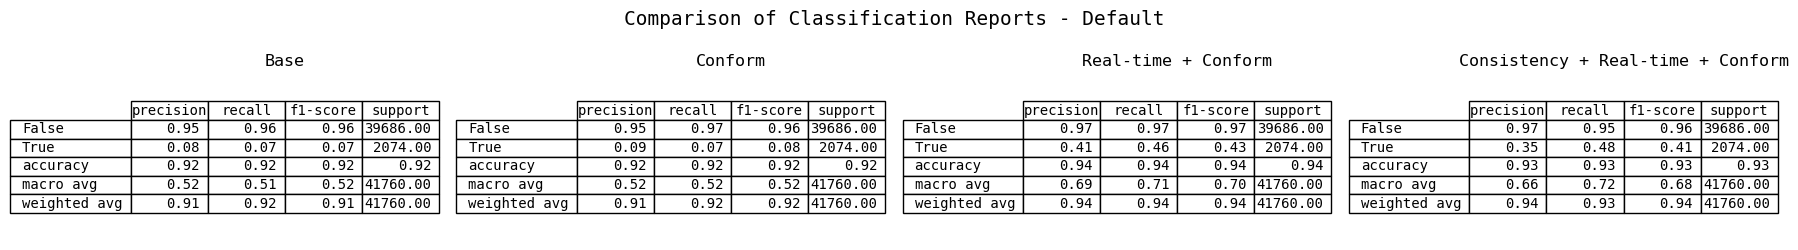

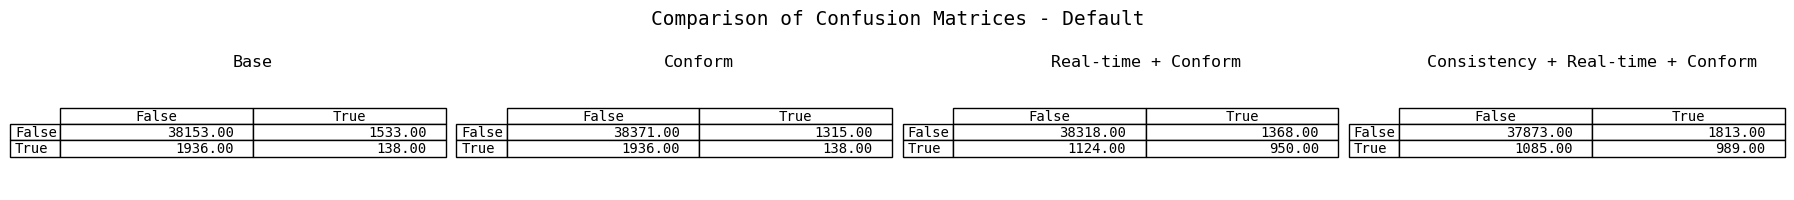

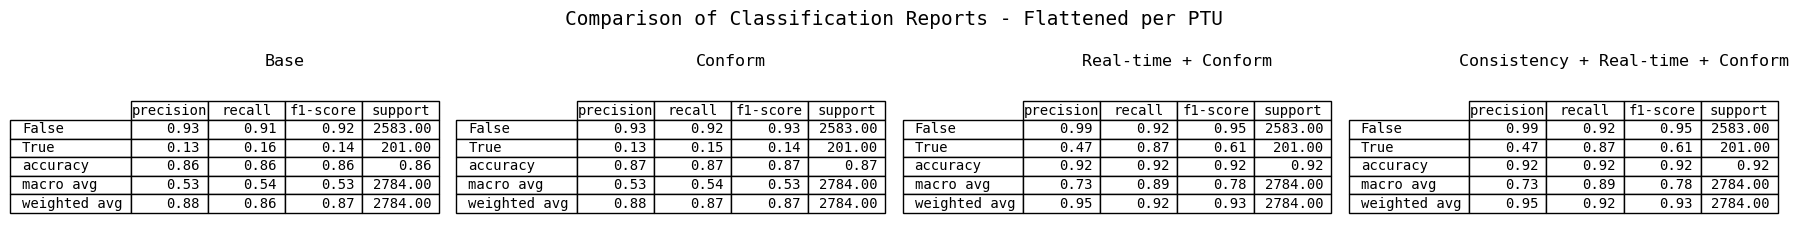

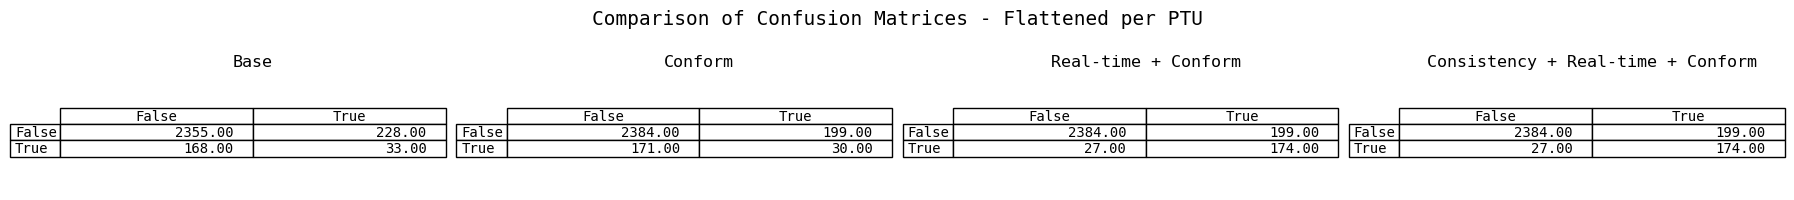

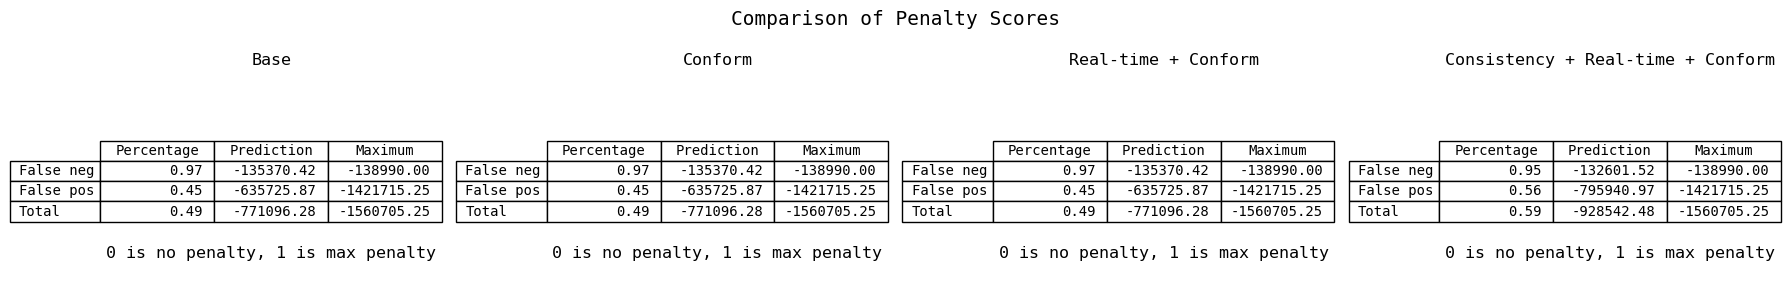

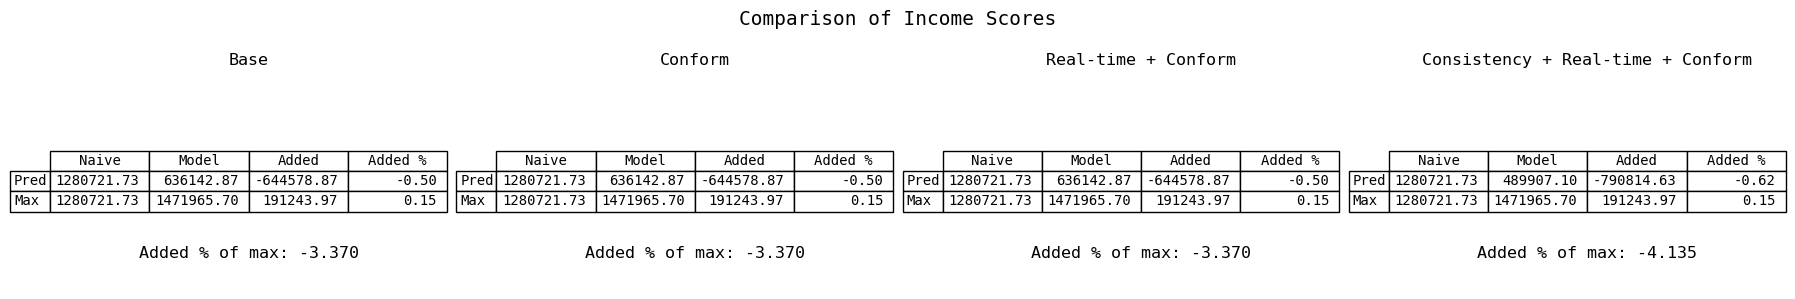

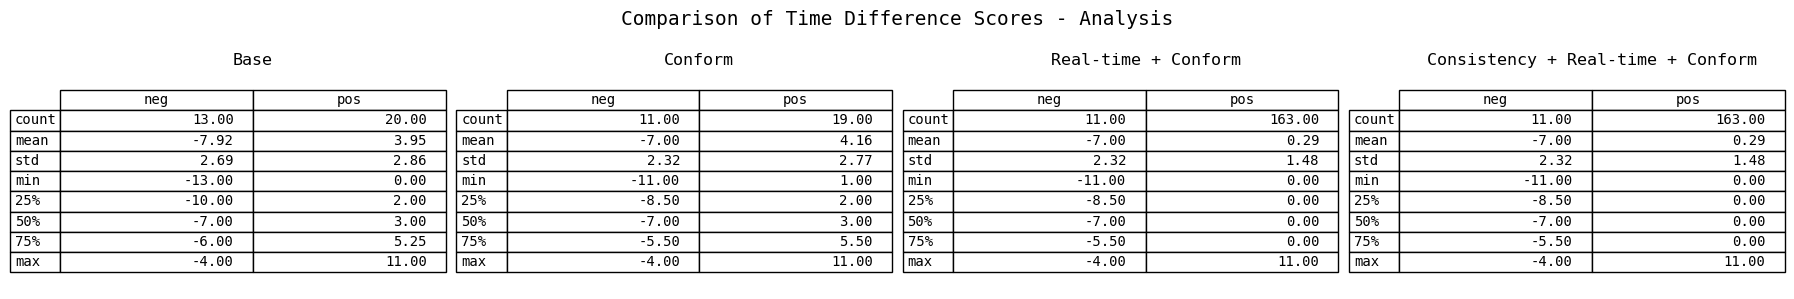

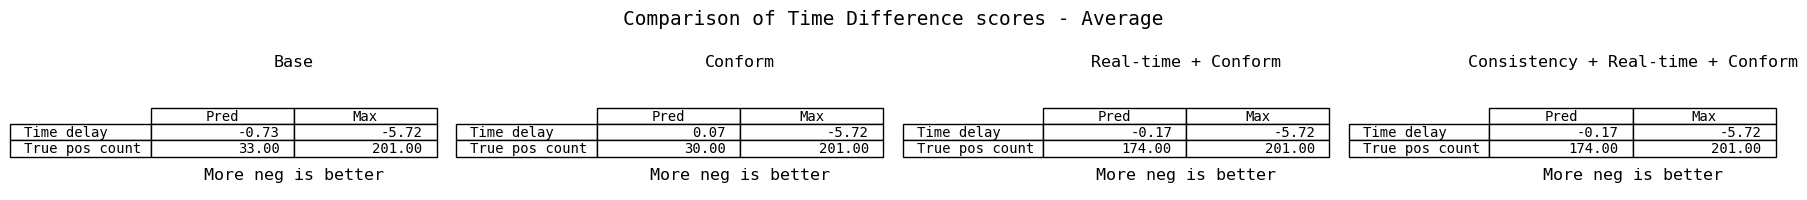

In [38]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "min_ptu_price_known",
    "max_ptu_price_known",
    "fix_min_ptu_price_known",  # combine all
    "fix_max_ptu_price_known",  # combine all
    "fix_settlement_price_bestguess_alt",  # combine all
    "settlement_price_bestguess_alt",
    # "upward_dispatch_published",
    # "downward_dispatch_published",
    # "igcc_contribution_up_published",
    # "igcc_contribution_down_published",
    "time_since_last_two_sided",
    "time_since_last_two_sided_alt",  # combine all
    "two_sided_daily_count",
    "PTU",
    "minute_in_ptu",
    "naive_strategy_action",
    "vwap_avg",
    "vwap_std",
    "vwap_median",
    "vwap_qty_sum",
    "hvq_delta",
    # "forecast_wind",
    # "forecast_solar",
    # "forecast_demand",
    "forecast_wind_delta",
    "forecast_solar_delta",
    "forecast_demand_delta",
    "fix_two_sided_ptu_realtime",
    "residual_load",
    "dispatch_diff",
    "igcc_diff",
    "is_balanced",
    "weekday",
    "workday",
    # "hour",
    "month",
    # "day",
    # "minute",
    "down_negative",
    "down_price_volume",
    "up_price_volume",
    # "diff_price_volume",
    # "started_down"
] + lagged_features
print("Number of used features:", len(features))
splits = get_splits(df, features, target, return_dict_pair=False)

mask = splits[train_set][3]["started_down"]

t = np.ones(len(mask), dtype=bool)
t[:15 * 2] = False
t[-15 * 2:] = False
mask = mask & t

# Check if CUDA (GPU) is available and set the device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Create PyTorch datasets and dataloaders
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, action, price):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).reshape((len(y), 1)).to(device)
        self.action = torch.tensor(action, dtype=torch.bool).reshape((len(action), 1)).to(device)
        self.price = torch.tensor(price, dtype=torch.float32).reshape((len(price), 1)).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.action[idx], self.price[idx]


mask = ~splits[train_set][1].astype(bool) & t

train_dataset = CustomDataset(
    splits[train_set][0][mask].fillna(0).values.astype(np.float32),
    splits[train_set][1][mask].values.astype(np.float32),
    splits[train_set][3]["naive_strategy_action"].values.astype(np.bool_),
    splits[train_set][3]["settlement_price_realized"].values.astype(np.float32)
)
test_dataset = CustomDataset(
    splits[test_set][0].fillna(0).values.astype(np.float32),
    splits[test_set][1].values.astype(np.float32),
    splits[test_set][3]["naive_strategy_action"].values.astype(np.bool_),
    splits[test_set][3]["settlement_price_realized"].values.astype(np.float32)
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Function to validate the model
def validate_model(model, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, *_ in val_loader:
            reconstructed = model(X_batch)
            loss = criterion(reconstructed, X_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    return val_loss

model = Autoencoder(input_dim=splits[train_set][0].shape[1]).to(device)
# model.load_state_dict(load_model("autoencoder", "custom_loss"))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.05)
criterion = nn.MSELoss()
max_epochs = 100

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
early_stopping_counter = 0
best_val_loss = np.inf
best_model = None

# Training loop
for epoch in range(max_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch, action_batch, price_batch in train_loader:
        optimizer.zero_grad()
        reconstructed = model(X_batch)
        loss = criterion(reconstructed, X_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    val_loss = validate_model(model, val_loader)
    print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")
    
    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        save_model(best_model, "autoencoder", "custom_loss")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    # Early stopping logic
    if early_stopping_counter >= patience:
        print(f'Early stopping after epoch {epoch+1} with no improvement.')
        break

# Load the best model weights
if best_model:
    model.load_state_dict(best_model)

X_test = splits[test_set][0].fillna(0).values.astype(np.float32)
y_test = splits[test_set][1].values.astype(np.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    reconstructed = model(X_test_tensor)
    reconstruction_error = torch.mean((X_test_tensor - reconstructed) ** 2, dim=1).cpu().numpy()

# Determine the threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 96)  # Adjust the percentile based on your needs

# Predict anomalies
y_pred = (reconstruction_error > threshold).astype(bool)

show_metrics_adjusted(splits[test_set][3], pd.Series(y_pred), version=version)


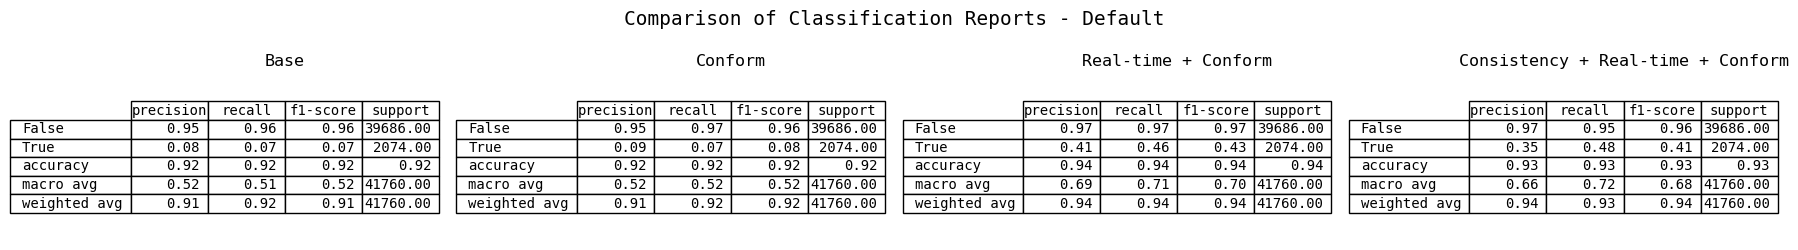

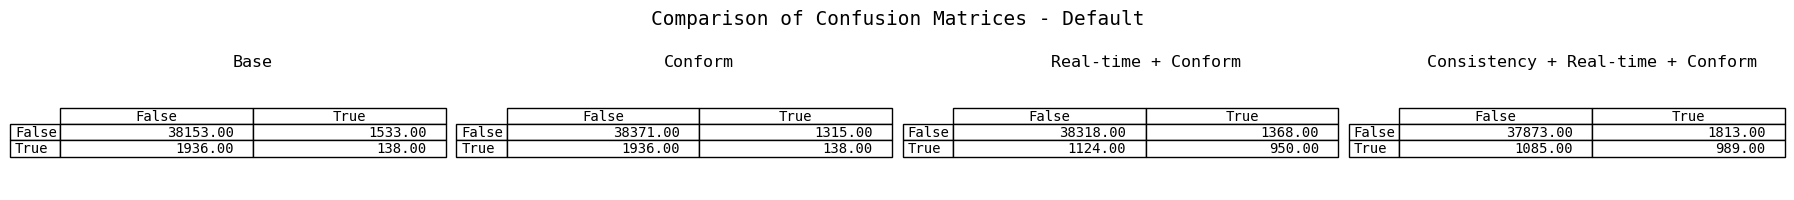

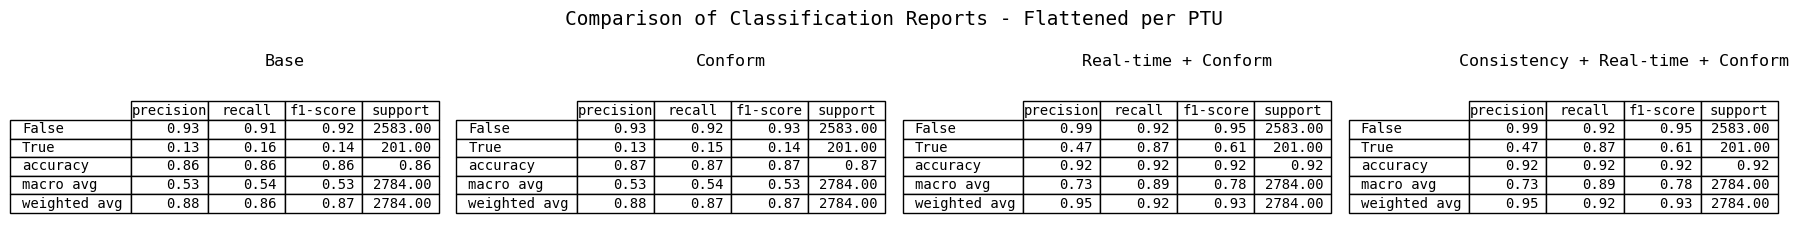

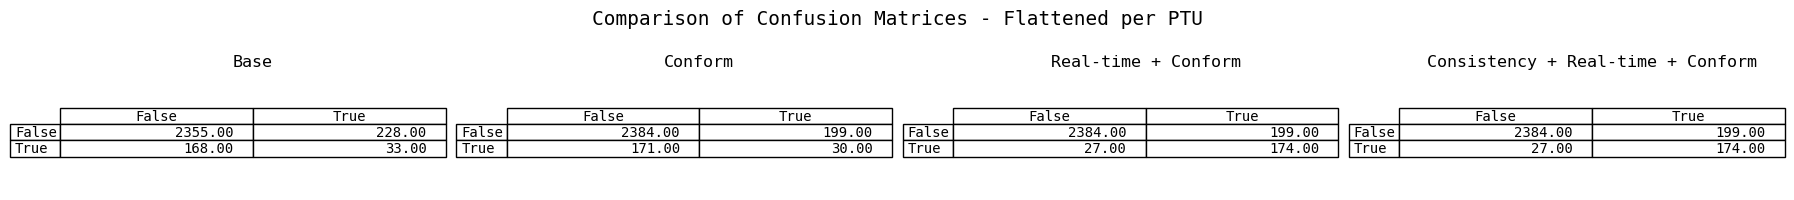

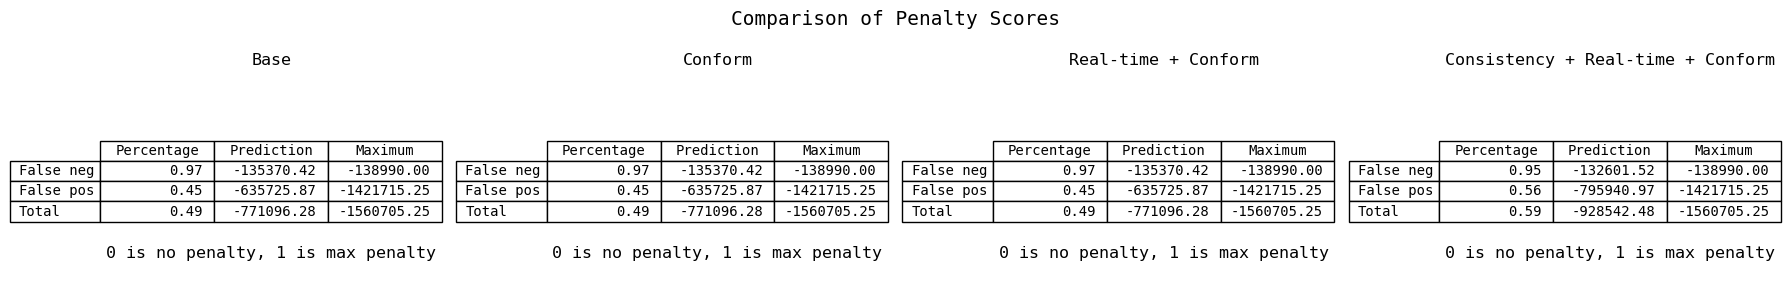

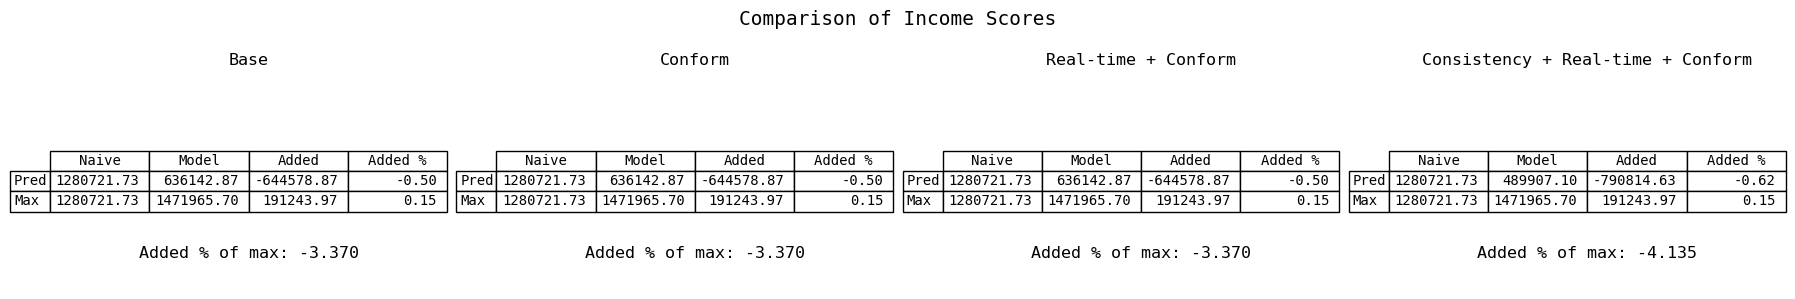

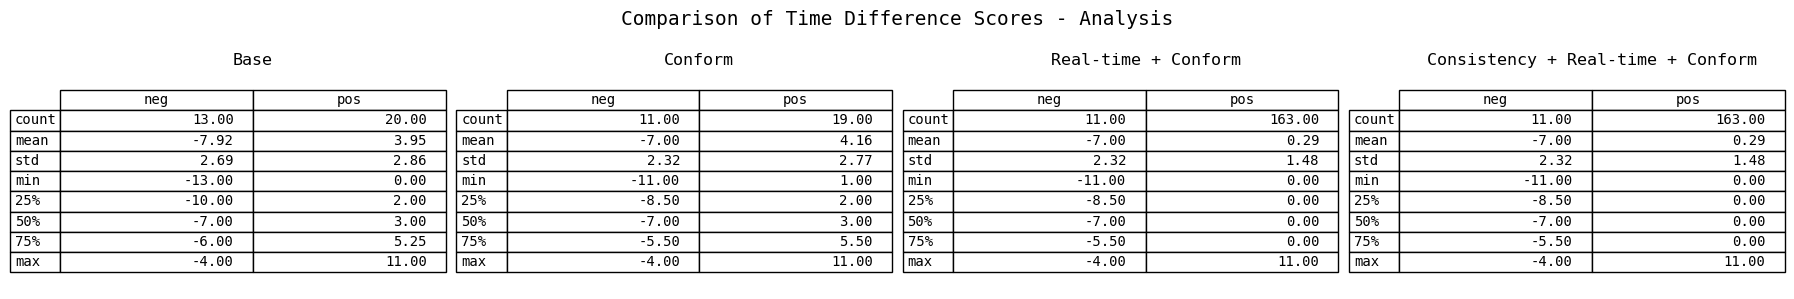

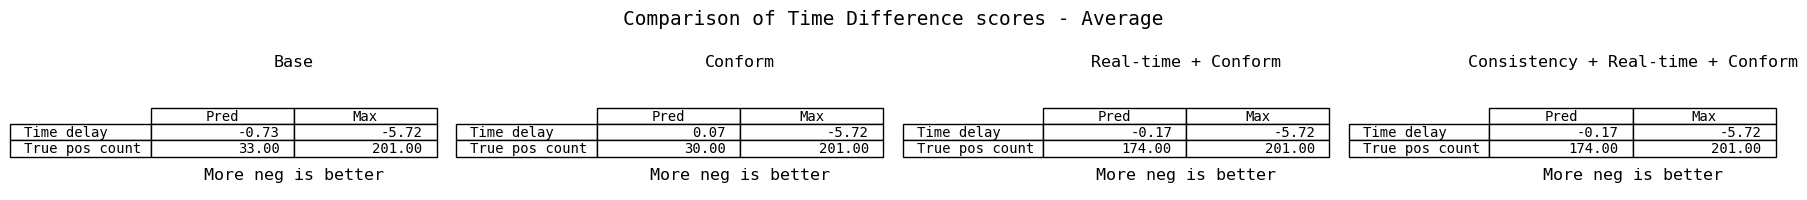

In [39]:
# Determine the threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 96)  # Adjust the percentile based on your needs

# Predict anomalies
y_pred = (reconstruction_error > threshold).astype(bool)

show_metrics_adjusted(splits[test_set][3], pd.Series(y_pred), version=version)

In [40]:
p_tr, _ = test(best[0], splits["train"][0])
show_metrics_adjusted(splits["train"][3], p_tr, version=version)

p_va, _ = test(best[0], splits["valid"][0])
show_metrics_adjusted(splits["valid"][3], p_va, version=version)

p_te, _ = test(best[0], splits["test"][0])
show_metrics_adjusted(splits["test"][3], p_te, version=version)

NameError: name 'test' is not defined

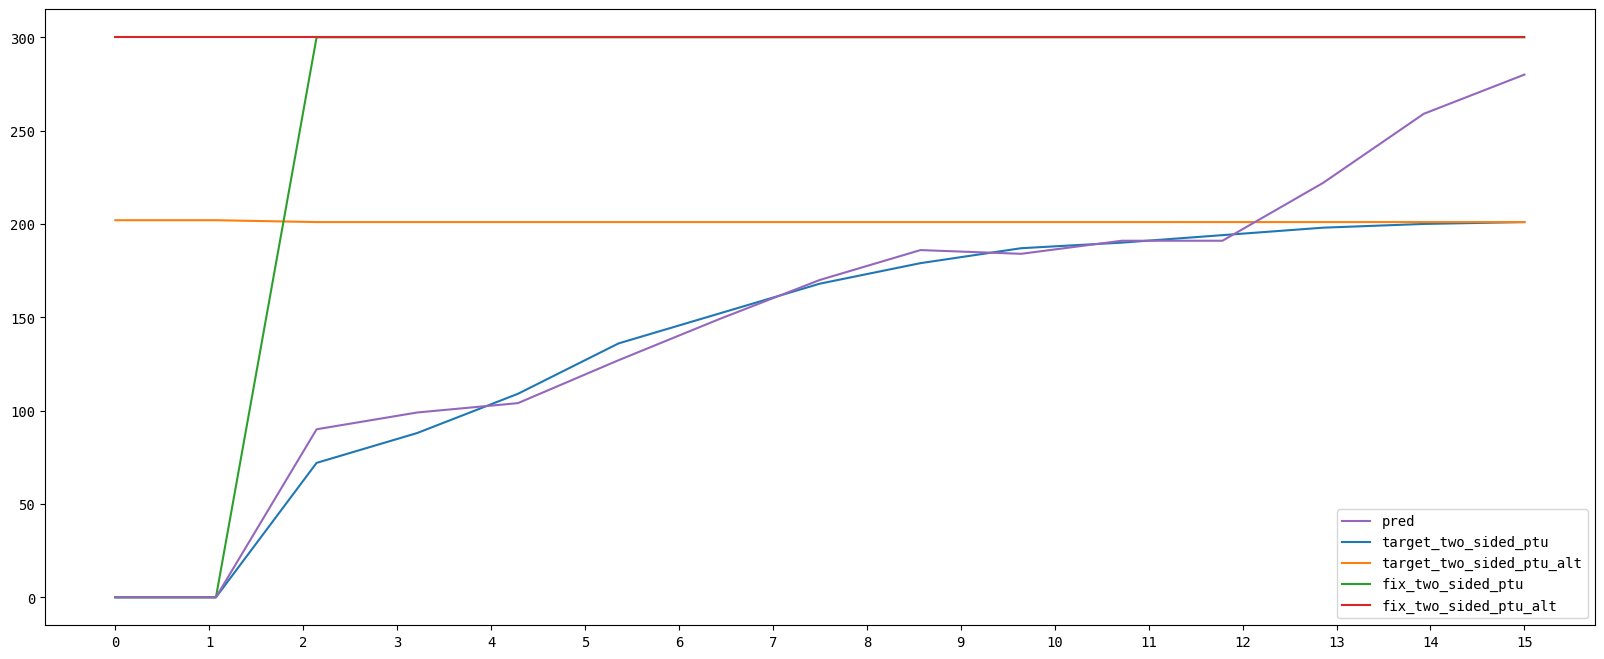

In [ ]:
targets = [
    "target_two_sided_ptu",
    "target_two_sided_ptu_alt",
    # "target_two_sided_ptu_realtime",
    "fix_two_sided_ptu",
    "fix_two_sided_ptu_alt",
    # "fix_two_sided_ptu_realtime",
    "pred"
]
agg_dict = {t: "sum" for t in targets}
view = splits[test_set][3]
view["pred"] = p1
items = 15
flat_df = view.groupby("minute_in_ptu").agg(agg_dict)
flat_df.index = np.linspace(0, items, items)

for t in targets:
    plot_against_index(flat_df[t], show=False)
plt.xticks(range(0, items + 1, 1))
show_graph()